In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from sqlalchemy import create_engine

# Database connection settings
CONNECTION_STRING = 'postgresql+psycopg2://kiliansprenkamp@localhost:5432/telegram_scraper'
ENGINE = create_engine(CONNECTION_STRING)

# Narrative columns (exact names from database)
NARRATIVE_COLUMNS = [
    'denazificationofukraine__similarity',
    'protectionofrussianspeakers__similarity',
    'natoexpansionthreat__similarity',
    'biolabsconspiracy__similarity',
    'ukraineasafailedstate__similarity',
    'historicalunityofrussiaandukraine__similarity',
    'westernrussophobia__similarity',
    'sanctionsaseconomicwarfare__similarity',
    'legitimizationofannexedterritories__similarity',
    'discreditingukrainianleadership__similarity'
]

# Prettier display names (for plots/output)
NARRATIVE_DISPLAY_NAMES = {
    'denazificationofukraine__similarity': "Denazification of Ukraine",
    'protectionofrussianspeakers__similarity': "Protection of Russian Speakers",
    'natoexpansionthreat__similarity': "NATO Expansion Threat",
    'biolabsconspiracy__similarity': "Biolabs Conspiracy",
    'ukraineasafailedstate__similarity': "Ukraine as a Failed State",
    'historicalunityofrussiaandukraine__similarity': "Historical Unity",
    'westernrussophobia__similarity': "Western Russophobia",
    'sanctionsaseconomicwarfare__similarity': "Sanctions as Economic Warfare",
    'legitimizationofannexedterritories__similarity': "Legitimization of Annexed Territories",
    'discreditingukrainianleadership__similarity': "Discrediting Ukrainian Leadership"
}

def load_table_in_chunks(table_name, columns="*", condition=None, description=None, chunk_size=250000):
    """Load a table in chunks with a progress bar"""
    query = f"SELECT {columns} FROM {table_name}"
    if condition:
        query += f" WHERE {condition}"
    
    # Get total count first
    with ENGINE.connect() as conn:
        count_query = f"SELECT COUNT(*) as count FROM ({query}) as subquery"
        total_rows = pd.read_sql_query(count_query, conn).iloc[0]['count']
    
    # Load in chunks
    chunks = []
    num_chunks = math.ceil(total_rows / chunk_size)
    
    with tqdm(total=total_rows, desc=description or f"Loading {table_name}") as pbar:
        for i in range(num_chunks):
            offset = i * chunk_size
            chunk_query = f"{query} LIMIT {chunk_size} OFFSET {offset}"
            
            with ENGINE.connect() as conn:
                chunk = pd.read_sql_query(chunk_query, conn)
            
            chunks.append(chunk)
            pbar.update(len(chunk))
    
    return pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()

# Check which tables are available in the database
with ENGINE.connect() as conn:
    # Query to get all tables in our database
    tables_query = "SELECT table_name FROM information_schema.tables WHERE table_schema='public'"
    available_tables = pd.read_sql_query(tables_query, conn)['table_name'].tolist()
    
print(f"Available tables in database: {available_tables}")

community_df = load_table_in_chunks('classified_messages_community', 
                                   description="Loading classified community messages")

# Load classified news messages
news_df = load_table_in_chunks('classified_messages_news',
                              description="Loading classified news messages")

Available tables in database: ['messages_news', 'messages_community', 'messages_community_debug', 'classified_messages_community', 'classified_messages_news', 'messages_community_with_bot_status']


Loading classified news messages: 100%|██████████| 2201902/2201902 [00:31<00:00, 70745.12it/s]


In [9]:
import pandas as pd

# Define your threshold and narrative columns
threshold = 0.6
narrative_columns = [
    'denazificationofukraine_similarity',
    'protectionofrussianspeakers_similarity',
    'natoexpansionthreat_similarity',
    'biolabsconspiracy_similarity',
    'ukraineasafailedstate_similarity',
    'historicalunityofrussiaandukraine_similarity',
    'westernrussophobia_similarity',
    'sanctionsaseconomicwarfare_similarity',
    'legitimizationofannexedterritories_similarity',
    'discreditingukrainianleadership_similarity'
]

# Option 1: Create a single narrative column (comma-separated if multiple exceed threshold)
def extract_narratives(row):
    narratives = []
    for col in narrative_columns:
        if row[col] > threshold:
            # Clean the column name if needed (removing "_similarity")
            narrative_name = col.replace('_similarity', '')
            narratives.append(narrative_name)
    return ', '.join(narratives)

# Process community messages
community_df['narrative'] = community_df.apply(extract_narratives, axis=1)
print("Community DataFrame with combined narratives:")
print(community_df[['messagetext', 'narrative']].head())

# Process news messages 
news_df['narrative'] = news_df.apply(extract_narratives, axis=1)
print("\nNews DataFrame with combined narratives:")
print(news_df[['messagetext', 'narrative']].head())

# Option 2: Explode the narratives so each row has a single narrative
def extract_narrative_list(row):
    narratives = []
    for col in narrative_columns:
        if row[col] > threshold:
            narrative_name = col.replace('_similarity', '')
            narratives.append(narrative_name)
    return narratives

# Process community messages
community_df['narrative_list'] = community_df.apply(extract_narrative_list, axis=1)
community_exploded = community_df.explode('narrative_list')
print("\nExploded Community DataFrame (one narrative per row):")
print(community_exploded.head())

# Process news messages
news_df['narrative_list'] = news_df.apply(extract_narrative_list, axis=1)
news_exploded = news_df.explode('narrative_list')
print("\nExploded News DataFrame (one narrative per row):")
print(news_exploded.head())


Community DataFrame with combined narratives:
                                         messagetext narrative
0  Нахер не нужен этот Зомбилэнд на русской земле...          
1                Хамелеон гибридный этот Столтенберг          
2                  В ответе за тех - кого приручили👍          
3                     Сучок он, и фашист к тому же!😠          
4  вопрос в том, как это будет реализовано, огонь...          

News DataFrame with combined narratives:
                                         messagetext narrative
0  В Липецке дачники, протестующие из-за сноса их...          
1  Цитаты Свободы\n\nСергей Кальварский: Первые с...          
2  🇷🇺🇺🇦Продолжая тему "обычного торгового центра"...          
3  Теперь понятно, что будет после перехода Украи...          
4  🇦🇲🇷🇺🇺🇦 Важная деталь: акция в поддержку Россий...          

Exploded Community DataFrame (one narrative per row):
   record_id        id                                        messagetext  \
0    2340649  18185447  

In [11]:
# filter for solely narratives with similarity > 0.6
community_exploded = community_exploded[community_exploded['narrative_list'].str.len() > 0]
news_exploded = news_exploded[news_exploded['narrative_list'].str.len() > 0]

print("\nFiltered Community DataFrame (only narratives with similarity > 0.6):")
print(community_exploded.head())



Filtered Community DataFrame (only narratives with similarity > 0.6):
     record_id        id                                        messagetext  \
270    2340920  18185813  Зеленский это уже давно не президент Украины, ...   
314    2340963  18185868  Да уж, западная политика всегда делает все не ...   
321    2340970  18185877  Зеленскому не отмыться от того позора, на кото...   
341    2340990  18185902  Лицемерие Запада видно во всем. Они даже украи...   
546    2341194  18186201  Зеленский начал войну в 2014 году и стал причи...   

        chat_id                chat_name     messagedatetime  \
270  1366415996  https://t.me/readovchat 2024-10-05 10:28:41   
314  1366415996  https://t.me/readovchat 2024-10-05 10:38:16   
321  1366415996  https://t.me/readovchat 2024-10-05 10:41:04   
341  1366415996  https://t.me/readovchat 2024-10-05 10:48:22   
546  1366415996  https://t.me/readovchat 2024-10-05 12:00:38   

     denazificationofukraine_similarity  \
270                       

In [14]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-ru-go-emotions", device="mps") 

In [16]:
from tqdm.auto import tqdm

#apply model to messagetext
# Helper function to extract sentiment info
def get_sentiment(text):
    result = model(text)[0]
    return pd.Series([result['label'], result['score']], index=['sentiment_label', 'sentiment_score'])

# Apply sentiment analysis to both dataframes efficiently with progress bars
tqdm.pandas(desc="Analyzing community messages")
community_exploded[['sentiment_label', 'sentiment_score']] = community_exploded['messagetext'].progress_apply(get_sentiment)

tqdm.pandas(desc="Analyzing news messages") 
news_exploded[['sentiment_label', 'sentiment_score']] = news_exploded['messagetext'].progress_apply(get_sentiment)

print("\nCommunity messages with sentiment:")
print(community_exploded[['messagetext', 'narrative_list', 'sentiment_label', 'sentiment_score']].head())
print("\nNews messages with sentiment:")
print(news_exploded[['messagetext', 'narrative_list', 'sentiment_label', 'sentiment_score']].head())




Analyzing community messages:   0%|          | 0/11659 [00:00<?, ?it/s]

Analyzing news messages:   0%|          | 0/36508 [00:00<?, ?it/s]

/var/folders/jx/2l7p1chd2l7djbz_8s3s_4z80000gn/T/ipykernel_87300/3385512034.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_exploded[['sentiment_label', 'sentiment_score']] = news_exploded['messagetext'].progress_apply(get_sentiment)
/var/folders/jx/2l7p1chd2l7djbz_8s3s_4z80000gn/T/ipykernel_87300/3385512034.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_exploded[['sentiment_label', 'sentiment_score']] = news_exploded['messagetext'].progress_apply(get_sentiment)



Community messages with sentiment:
                                           messagetext  \
270  Зеленский это уже давно не президент Украины, ...   
314  Да уж, западная политика всегда делает все не ...   
321  Зеленскому не отмыться от того позора, на кото...   
341  Лицемерие Запада видно во всем. Они даже украи...   
546  Зеленский начал войну в 2014 году и стал причи...   

                      narrative_list sentiment_label  sentiment_score  
270  discreditingukrainianleadership         neutral         0.430840  
314  discreditingukrainianleadership         neutral         0.559310  
321  discreditingukrainianleadership           anger         0.467137  
341  discreditingukrainianleadership         neutral         0.342305  
546            ukraineasafailedstate      admiration         0.704155  

News messages with sentiment:
                                           messagetext  \
134  Зеленский продолжает накачивать население Укра...   
186  В комментах пишут "Москва не вс

/var/folders/jx/2l7p1chd2l7djbz_8s3s_4z80000gn/T/ipykernel_87300/3903308131.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(all_sentiments)))


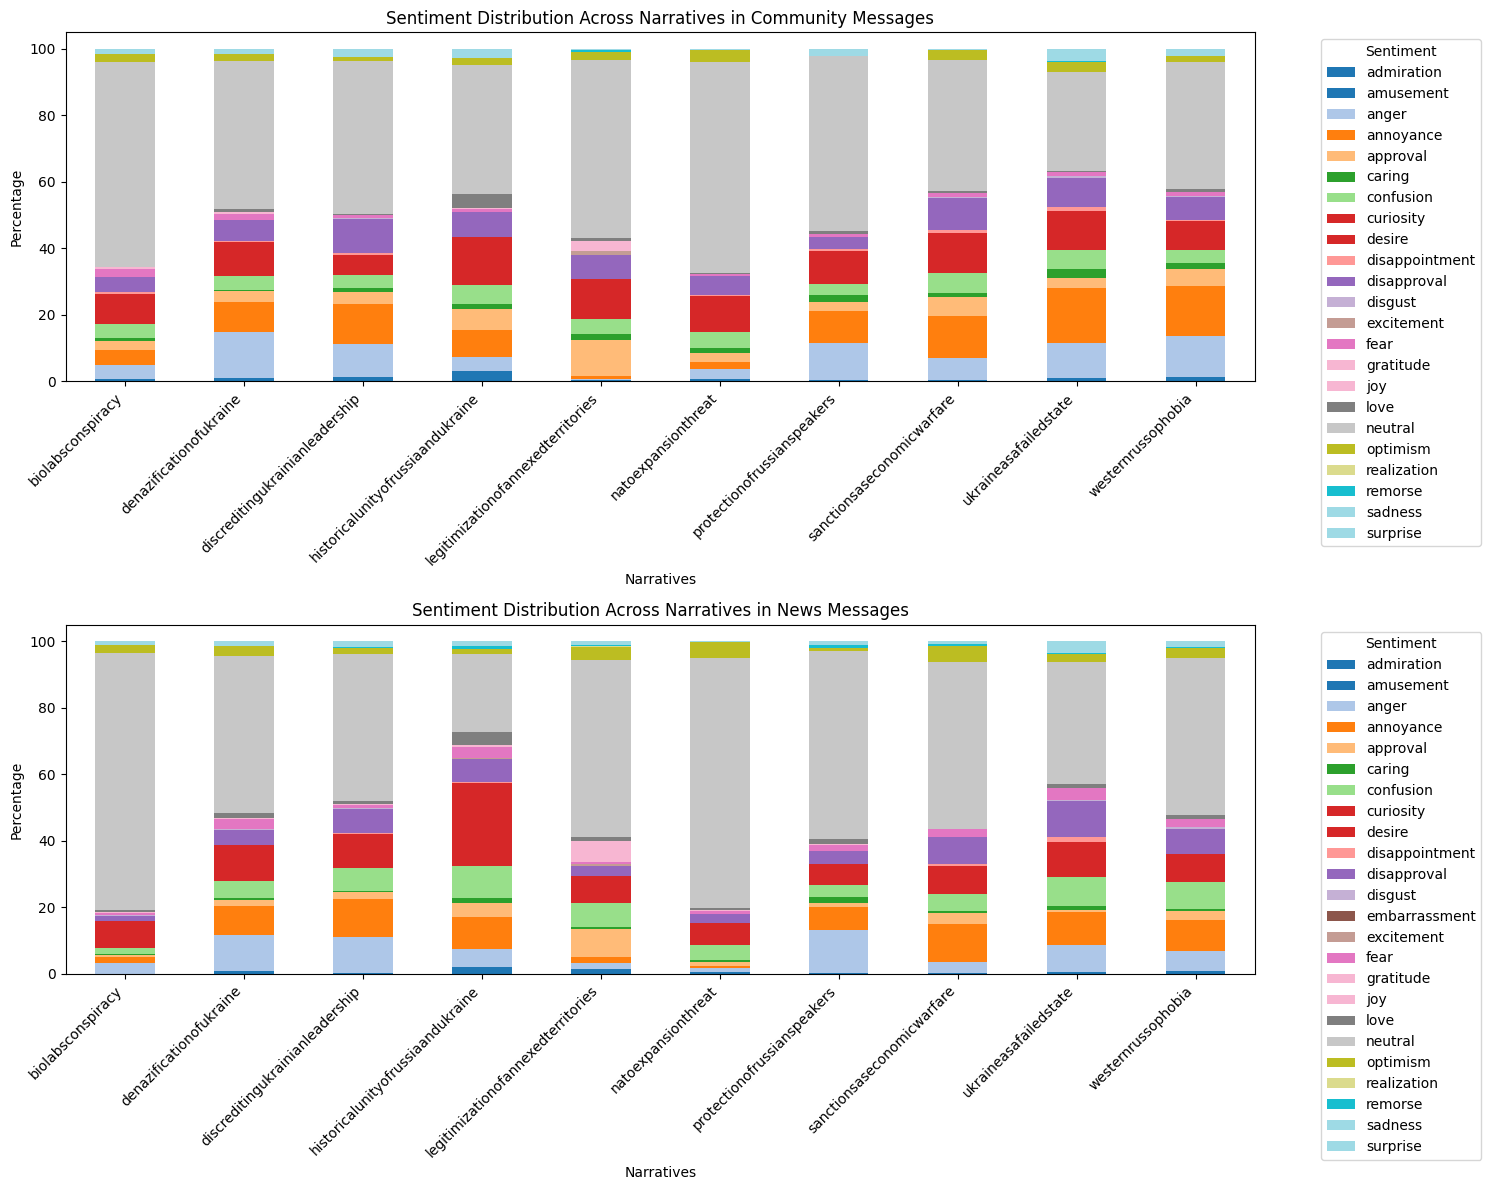

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to process data for visualization
def prepare_sentiment_data(df):
    # Explode narrative_list to get one row per narrative-message pair
    narrative_sentiments = df.explode('narrative_list')[['narrative_list', 'sentiment_label']]
    
    # Calculate percentage of each sentiment per narrative
    sentiment_dist = pd.crosstab(narrative_sentiments['narrative_list'], 
                                narrative_sentiments['sentiment_label'], 
                                normalize='index') * 100
    return sentiment_dist

# Prepare data for both datasets
community_sentiments = prepare_sentiment_data(community_exploded)
news_sentiments = prepare_sentiment_data(news_exploded)

# Get all unique sentiments and create a consistent color map
all_sentiments = sorted(set(community_sentiments.columns) | set(news_sentiments.columns))
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(all_sentiments)))
color_dict = dict(zip(all_sentiments, colors))

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot community sentiments
community_sentiments.plot(kind='bar', stacked=True, ax=ax1, color=[color_dict[s] for s in community_sentiments.columns])
ax1.set_title('Sentiment Distribution Across Narratives in Community Messages')
ax1.set_xlabel('Narratives')
ax1.set_ylabel('Percentage')
ax1.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot news sentiments
news_sentiments.plot(kind='bar', stacked=True, ax=ax2, color=[color_dict[s] for s in news_sentiments.columns])
ax2.set_title('Sentiment Distribution Across Narratives in News Messages')
ax2.set_xlabel('Narratives')
ax2.set_ylabel('Percentage')
ax2.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [23]:
# Calculate narrative distributions and return as dataframes
def get_narrative_distributions(df, dataset_name):
    # Explode the narrative_list column and reset index
    exploded_df = df.explode('narrative_list').reset_index(drop=True)
    
    # Get absolute counts and relative distributions as a combined dataframe
    abs_counts = pd.crosstab(exploded_df['narrative_list'], 
                            exploded_df['sentiment_label'])
    rel_dist = pd.crosstab(exploded_df['narrative_list'], 
                          exploded_df['sentiment_label'],
                          normalize='index') * 100
    
    # Combine into a single dataframe with MultiIndex columns
    combined_df = pd.concat([abs_counts, rel_dist], axis=1, keys=['Counts', 'Percentages'])
    
    return combined_df
    # Create a formatted table header
    sentiments = abs_counts.columns
    header = "Narrative"
    for sentiment in sentiments:
        header += f" | {sentiment:^20}"
    print(header)
    print("-" * len(header))
    
    # Print each narrative's statistics in table rows
    for narrative in abs_counts.index:
        row = f"{narrative:<30}"
        for sentiment in sentiments:
            abs_count = abs_counts.loc[narrative, sentiment]
            rel_pct = rel_dist.loc[narrative, sentiment]
            row += f" | {abs_count:>6} ({rel_pct:>6.1f}%)"
        print(row)
    print()

# Display distributions for both datasets
print_narrative_distributions(community_exploded, "Community Messages")
print_narrative_distributions(news_exploded, "News Messages")



Community Messages Narrative Distributions:
--------------------------------------------------------------------------------
Narrative |      admiration      |      amusement       |        anger         |      annoyance       |       approval       |        caring        |      confusion       |      curiosity       |        desire        |    disappointment    |     disapproval      |       disgust        |      excitement      |         fear         |      gratitude       |         joy          |         love         |       neutral        |       optimism       |     realization      |       remorse        |       sadness        |       surprise      
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------